# Chapter 4: Statistical Inference.

In this notebook we will see how to infer predictions about a population. To
this end we will explore the relationship between sample parameters and population parameters and we will propose some methods to assess the quality
of parameter estimates of a sample.

## Data description

Let's consider a dataset of accidents in Barcelona in 2013. This dataset can
be downloaded from OpenDataBCN website (http://opendata.bcn.cat/),
Barcelona's City Hall open data service. Each register in the dataset represents an accident by a series of features: weekday, hour, address, number
of dead and injured people, etc. This dataset will represent our population:
the set of all reported traffic accidents in Barcelona during 2013.

In https://dieguico.cartodb.com/viz/50b06d8c-13ab-11e5-8619-0e4fddd5de28/public_map you can visualize a map of accidents in the city of Barcelona by hour of day, and by day of week.

In [1]:
import matplotlib.pylab as plt
from matplotlib import cm
import math
import pandas as pd
import numpy as np
import random

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 

In [2]:
data = pd.read_csv("files/ch04/ACCIDENTS_GU_BCN_2013.csv", encoding='latin-1')
print(data.columns)

Index(['Número d'expedient', 'Codi districte', 'Nom districte', 'NK barri',
       'Nom barri', 'Codi carrer', 'Nom carrer', 'Num postal caption',
       'Descripció dia setmana', 'Dia de setmana', 'Descripció tipus dia',
       'NK Any', 'Mes de any', 'Nom mes', 'Dia de mes', 'Hora de dia',
       'Descripció torn', 'Descripció causa vianant', 'Número de morts',
       'Número de lesionats lleus', 'Número de lesionats greus',
       'Número de víctimes', 'Número de vehicles implicats',
       'Coordenada UTM (Y)', 'Coordenada UTM (X)'],
      dtype='object')


We will create a new data column which is the date and a list with the number of accidents for every day of the year:

In [3]:
#Create a new column which is the date
data['Date'] = '2013-'+data['Mes de any'].apply(lambda x : str(x)) + '-' +  data['Dia de mes'].apply(lambda x : str(x))
data['Date'] = pd.to_datetime(data['Date'])
accidents = data.groupby(['Date']).size()
print("Mean:", accidents.mean())

Mean: 25.90958904109589


Let's suppose that we are interested in describing the number of daily traffic
accidents (**accident rate**) in the streets of Barcelona during 2013.  In order to get a first idea of the data, we can plot the number of accidents for each day of 2013:

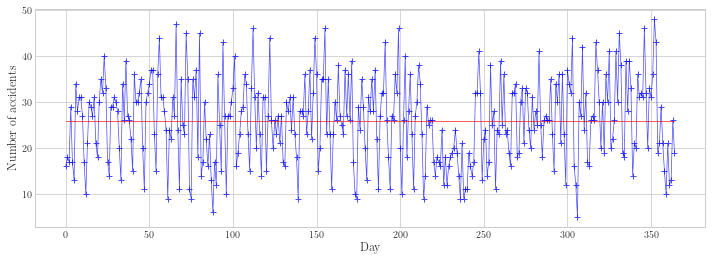

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.ylabel('Number of accidents')
plt.xlabel('Day')
plt.plot(range(0, 365), np.array(accidents), 'b-+', lw=0.7, alpha=0.7)
plt.plot(range(0, 365), [accidents.mean()]*365, 'r-', lw=0.7, alpha=0.9)
plt.show()

Alternatively, we can plot the distribution of our variable of interest: the daily number of accidents.

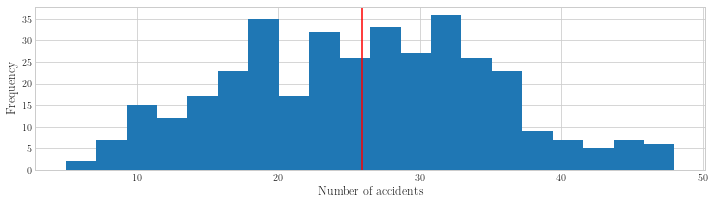

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.hist(np.array(accidents), bins=20)
ax.axvline(x=accidents.mean(), ymin=0, ymax=40, color=[1, 0, 0])
plt.savefig("bootmean.png",dpi=300, bbox_inches='tight')
plt.show()

If we have access to the whole *population*, the computation of the **accident rate** in 2013 is a simple operation: the total number of accidents divided by 365. As a measure of quality of this parameter we can also compute the standard deviation.

In [6]:
print("Mean:", accidents.mean(), "; STD:", accidents.std())

Mean: 25.90958904109589 ; STD: 9.108324962464705


But now, let's suppose that we have only access to a limited part of the data
(the *sample*): the number of accidents during *some days* of 2013. Can we still
give an approximation (an *estimate*) to this population mean?

## Variability in estimates.

Estimates generally vary from one sample to another, and this sampling variation suggests our estimate may be close, but it will not be exactly equal to the parameter.

This can be easily checked by generating 10 different samples (composed of 25% of the population) from our population and compute their accident rate estimates:

In [7]:
df = accidents.to_frame()
m = []

for i in range(10):
    df['for_testing'] = False
    # get a 25% sample 
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.25)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    accidents_sample = df[df['for_testing'] == True]
    m.append(accidents_sample[0].mean())
    print('Sample '+str(i)+': Mean', '%.2f' % accidents_sample[0].mean())


Sample 0: Mean 24.91
Sample 1: Mean 25.45
Sample 2: Mean 26.25
Sample 3: Mean 26.90
Sample 4: Mean 25.82
Sample 5: Mean 25.29
Sample 6: Mean 26.79
Sample 7: Mean 25.60
Sample 8: Mean 24.37
Sample 9: Mean 25.35


Text(0.5, 0, 'Sample')

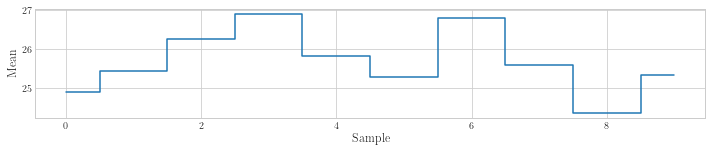

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
x = range(10)
ax.step(x,m, where='mid')
ax.set_ylabel('Mean')
ax.set_xlabel('Sample')

Accident rate estimates can range from 24 accident per day to 27 accidents per day, depending on the sample. How can we give a unique value for the estimate?

### Sampling distribution of point estimates

The most intuitive way to go about giving a value for the estimate is to simply take the *sample
mean*. The sample mean is a point estimate of the population mean. If we
can only choose one value to estimate the population mean, this is our best
guess.

Let's computer the sample means for a set of 10000 samples, each one composed of 200 days:

<Figure size 432x288 with 0 Axes>

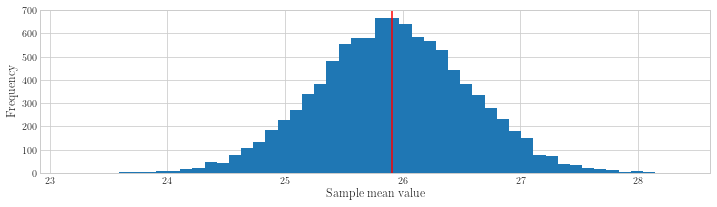

Sample mean: 25.910944


<Figure size 432x288 with 0 Axes>

In [9]:
plt.autumn()

# population
df = accidents.to_frame()    
N_test = 10000              
elements = 200             

# mean array of samples
means = [0] * N_test             

# sample generation
for i in range(N_test):          
    rows = np.random.choice(df.index.values, elements)
    sampled_df = df.loc[rows]
    means[i] = sampled_df.mean()
    
fig, ax = plt.subplots(1, 1, figsize=(12,3))

plt.hist(np.array(means),bins=50)
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
ax.axvline(x = np.array(means).mean(), 
           ymin = 0, 
           ymax = 700, 
           color = [1, 0, 0])
plt.savefig("empiricalmean.png",dpi=300, bbox_inches='tight')
plt.show()
plt.set_cmap(cmap=cm.Pastel2)

print("Sample mean:", np.array(means).mean())

This is the **sampling distribution of the mean**. From it we could estimate the most probable value of the mean and also its standard deviation, but in the real world we will not have access to this function!

### Standard error of the mean

Noe let's suppose that we have only one sample of the propulation. As comented before, the mean estimate from that sample may be close, but it will not be exactly equal to our parameter of interest (that can only be computed if we have access to the full population). For this reason it is interesting to measure its variability with respect to the sampling process. To this end we can use the *standard error of the mean*.

It can be mathematically shown that given $n$ independent observations $\{ x_i \}_{i=1,..,n}$ from a population with a standard deviation $\sigma_x$, the standard deviation of the sample mean $\sigma_{\bar{x}}$, or **standard error** is:

$$ SE = \frac{\sigma_{x}}{\sqrt{n}} $$

This allows **to estimate the standard deviation of the sample mean** even if we cannot perform the simulation process (f.e. because we have no access to the population). Usually, $\sigma_x$ is not known and it is substituted by its empirical estimate (that is sufficiently good of $n>30$ and the population distribution is not skewed):

In [10]:
rows = np.random.choice(df.index.values, 200)
sampled_df = df.loc[rows]
est_sigma_mean = sampled_df.std()/math.sqrt(200)

print('Direct estimation of SE from one sample of 200 elements:', \
       est_sigma_mean[0])
print('Estimation of the SE by simulating 10000 samples of 200 elements:',  \
       np.array(means).std())

Direct estimation of SE from one sample of 200 elements: 0.5867464160810184
Estimation of the SE by simulating 10000 samples of 200 elements: 0.6411950318460056


We could be also interested in quantifying the standard deviation of other estimates: median, standard deviation, etc., but unlike in the case of the sample mean, there is no simple formula for the standard
error of other interesting sample estimates, such as the median.

Let's consider from now the whole accidents dataset as a sample from an hypothetical population (this is the most common situation when analyzing real data!).

### Bootstrapping the standard error of the mean.

A modern alternative to the traditional approach to statistical inference is
the *bootstrapping method*. In the bootstrap, we draw $N$ observations with
replacement from the original data to create a bootstrap sample or resample.
Then, we can calculate the mean for this resample. By repeating this process
a large number of times we can built a good approximation of the mean
sampling distribution.

In [11]:
def meanBootstrap(X,numberb):
    import numpy as np
    x = [0]*numberb
    for i in range(numberb):
        sample = [X[_] for _ in np.random.randint(len(X), size=len(X))]
        x[i] = np.mean(sample)
    return x

m = meanBootstrap(accidents, 10000)
print("Mean estimate:", np.mean(m))

Mean estimate: 25.915641643835617


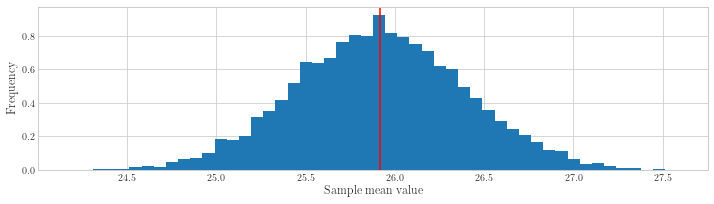

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.ylabel('Frequency')
plt.xlabel('Sample mean value')
plt.hist(m, 
         bins = 50, 
         density = True)
ax.axvline(x = np.mean(m), 
           ymin = 0.0, 
           ymax = 1.0, 
           color = [1, 0, 0])

The boostrapping method can be applied to other simple estimates such as
the median or the variance:

Median estimate: 26.3005


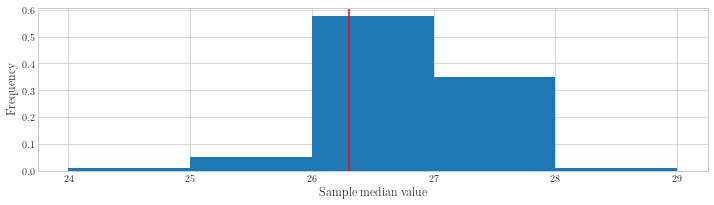

In [13]:
def medBootstrap(X,numberb):
    import numpy as np
    x = [0]*numberb
    for i in range(numberb):
        sample = [X[_] for _ in np.random.randint(len(X), size=len(X))]
        x[i] = np.median(sample)
    return x

med = medBootstrap(accidents, 10000)
print("Median estimate:", np.mean(med) )
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(med, bins=5, density=True)
plt.ylabel('Frequency')
plt.xlabel('Sample median value')
ax.axvline(x = np.array(med).mean(), 
           ymin = 0, 
           ymax = 1.0, 
           color = [1, 0, 0])

## Confidence intervals.

A point estimate provides a single plausible value for a parameter. However,
as we have seen a point estimate is rarely perfect; usually there is some error
in the estimate. That is why we have proposed to use the standard error as
a measure of its variability.

As an alternative, a next logical step would be to provide a **plausible range of
values** for the parameter. A plausible range of values for the sample parameter
is called a **confidence interval**.

We will base the definition of confidence interval on two ideas:

+ Our point estimate is the most plausible value of the parameter, so it makes sense to build the confidence interval around the point estimate.

+ The plausability of a range of values can be defined from the sampling distribution of the estimate.

In order to define an interval, we can make use of a well
known result from probability that applies to normal distributions: roughly
95% of the time our estimate will be within 1.96 standard errors of the true
mean of the distribution.

In [14]:
m = accidents.mean()
se = accidents.std()/math.sqrt(len(accidents))
ci = [m - se*1.96, m + se*1.96]
print("Confidence interval:", ci)

Confidence interval: [24.975156065800284, 26.8440220163915]


This is how we would compute a 95% confidence interval of the sample mean by using bootstrapping:

1. Repeat the following steps a large number $M$ of times: 
    + Draw $N$ observations with replacement from the original data to create a bootstrap sample or resample; 
    + Calculate the mean for the resample.
2. Calculate the **mean** of your $M$ values of the sample statistic. This process gives you a “bootstrapped” estimate of the sample statistic.
3. Calculate the **standard deviation** of your $M$ values of the sample statistic. This process gives you a “bootstrapped” estimate of the **SE** of the sample statistic.
4. Obtain the 2.5th and 97.5th centiles of your $M$ values values of the sample statistic.

In [15]:
m = meanBootstrap(accidents, 10000)
sample_mean = np.mean(m)
sample_se =  np.std(m)

print("Mean estimate:", sample_mean)
print("SE of the estimate:", sample_se)

ci = [np.percentile(m,2.5), np.percentile(m,97.5)]
print("Confidence interval:", ci)

Mean estimate: 25.910843561643837
SE of the estimate: 0.47927070407886707
Confidence interval: [24.958904109589042, 26.84931506849315]


### Waht is the real meaning of CI?

The real meaning of "confidence" is not evident and it must be understood
from the point of view of the generating process.

Suppose we take many (infinite) samples from a population and built a
95% confidence interval from each sample. Then about 95% of those intervals
would contain the actual parameter.

This can be easily showed by simulating a large number of samples and checking how many intervals contain the true parameter:

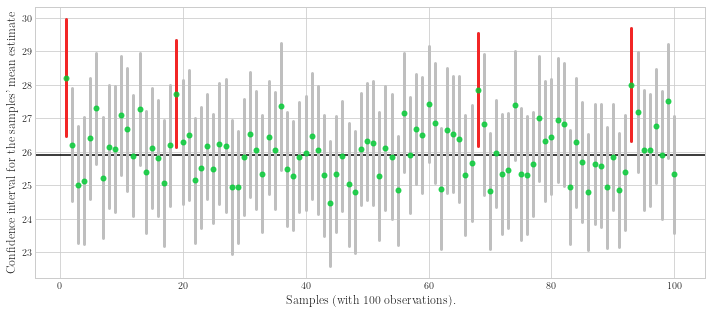

In [16]:
df = accidents   

n = 100                                               # number of observations
N_test = 100                                          # number of samples with n observations
means = np.array([0.0] * N_test)                      # samples' mean
s = np.array([0.0] * N_test)                          # samples' std
ci = np.array([[0.0,0.0]] * N_test)
tm = df.mean()                                        # "true" mean

for i in range(N_test):                               # sample generation and CI computation
    rows = np.random.choice(df.index.values, n)
    sampled_df = df.loc[rows]
    means[i] = sampled_df.mean()
    s[i] = sampled_df.std()
    ci[i] = means[i] + np.array([-s[i] *1.96/np.sqrt(n), s[i]*1.96/np.sqrt(n)])    

out1 = ci[:,0] > tm                                   # CI that do not contain the "true" mean
out2 = ci[:,1] < tm

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ind = np.arange(1, N_test+1)
ax.axhline(y = tm, 
           xmin = 0, 
           xmax = N_test+1, 
           color = [0, 0, 0])
ci = np.transpose(ci)
ax.plot([ind,ind], 
        ci, 
        color = '0.75', 
        marker = '_', 
        ms = 0, 
        linewidth = 3)
ax.plot([ind[out1],ind[out1]], 
        ci[:, out1], 
        color = [1, 0, 0, 0.8], 
        marker = '_', 
        ms = 0, 
        linewidth = 3)
ax.plot([ind[out2],ind[out2]], 
        ci[:, out2], 
        color = [1, 0, 0, 0.8], 
        marker = '_',
        ms = 0, 
        linewidth = 3)
ax.plot(ind, 
        means, 
        color = [0, .8, .2, .8], 
        marker = '.',
        ms = 10, 
        linestyle = '')
ax.set_ylabel("Confidence interval for the samples' mean estimate",
              fontsize = 12)
ax.set_xlabel('Samples (with %d observations). '  %n, 
              fontsize = 12)
plt.savefig("confidence.png",
            dpi = 300, 
            bbox_inches = 'tight')
plt.show()

## Hypothesis testing

To give a measure of variability of our estimates is a way of producing a
statistical proposition about the population, but not the only one. R.A.Fisher
(1890-1962) proposed an alternative, known as *hypothesis testing*, that is
based on the concept of *statistical significance*.

Let's suppose that a deeper analysis of traffic accidents in Barcelona results
in a difference between 2010 and 2013. Of course, the diference could be caused only by chance, because of the variability of both estimates. But it
could also be the case that traffic conditions are very diferent in Barcelona
during these two periods and, because of this, data from these two periods can
be considered as belonging to two diferent populations. Then, the relevant
question is: Are the observed effects real or not?

The process of determining the statistical significance of an effect is called
**hypothesis testing**. This process starts by simplifying the options into two
competing hypotheses:

+ $H_0$: The mean number of daily traffic accidents is the same in 2013 and 2010 (there is only one population, one true mean, and 2010 and 2013 are just different samples from the same population).

+ $H_A$: The mean number of daily traffic accidents for 2010 and for 2013 is different (2010 and 2013 are two samples from two different populations).

We call $H_0$ the *null hypothesis* and it represents a skeptical point of view:
the effect we have observed is due to chance (due to the specific sample bias).

$H_A$ is the *alternative hypothesis* and it represents the other point of view:
the effect is real.

The general rule of frequentist hypothesis testing is: We will not discard $H_0$
(and hence we will not consider $H_A$) unless the observed effect is implausible
under $H_0$.

### Testing hypotheses using confidence intervals.

We can use the concept represented by confidence intervals to measure the
plausibility of an hypothesis.

We can illustrate the evaluation of the hypotheses setup by comparing the
mean rate of traffic accidents in Barcelona during 2010 and 2013 using a point estimate from the 2013 sample:

In [17]:
data = pd.read_csv("files/ch04/ACCIDENTS_GU_BCN_2010.csv", encoding='latin-1')
#Create a new column which is the date
data['Date'] = data['Dia de mes'].apply(lambda x : str(x)) + '-' +  \
               data['Mes de any'].apply(lambda x : str(x))
data2 = data['Date']
counts2010 =data['Date'].value_counts()
print('2010: Mean', counts2010.mean())

data = pd.read_csv("files/ch04/ACCIDENTS_GU_BCN_2013.csv", encoding='latin-1')
#Create a new column which is the date
data['Date'] = data['Dia de mes'].apply(lambda x : str(x)) + '-' +  \
               data['Mes de any'].apply(lambda x : str(x))
data2 = data['Date']
counts2013 = data['Date'].value_counts()
print('2013: Mean', counts2013.mean())

2010: Mean 24.81095890410959
2013: Mean 25.90958904109589


This estimate suggests that during 2013 the mean rate of
traffic accidents in Barcelona **was higher** than 2010. But is this effect statistically significant?

Based on our sample, the 95% confidence interval for the mean rate of
traffic accidents in Barcelona during 2013 can be calculated as:

In [18]:
n = len(counts2013)
mean = counts2013.mean()
s = counts2013.std()
ci = [mean - s*1.96/np.sqrt(n),  mean + s*1.96/np.sqrt(n)] 
print('2010 accident rate estimate:', counts2010.mean())
print('2013 accident rate estimate:', counts2013.mean())
print('CI for 2013:',ci)

2010 accident rate estimate: 24.81095890410959
2013 accident rate estimate: 25.90958904109589
CI for 2013: [24.975156065800284, 26.8440220163915]


Because 2010 accident rate estimate does not fall in the range of plausible values of 2013, we say the
alternative hypothesis cannot be discarted. That is, it can not be discarted that during 2013 the mean rate of traffic accidents in Barcelona was higher than during 2010.

### Testing hypotheses using P-values.

A more advanced notion of statistical significance was developed by R.A.Fisher
in the 1920's when looking for a test to decide whether variation in crop yields
were due to some specific intervention or merely randon factors beyond experimental control.
Fisher first assumed that fertilizer caused no difference (null hypothesis)
and then calculated $P$, the probability that an observed yield in a fertilized
field would occur if fertilizer had no real effect. This probability is called
p-value.

The p-value is the probability of observing data at least as favorable to
the alternative hypothesis as our current data set, if the null hypothesis is
true.

To apply a test of hypotheses to our problem, the first step is to quantify the size of the apparent effect by choosing a test statistic. In our case, the apparent effect is a difference in accident
rates, so a natural choice for the test statistic is the difference in means
between the two periods:

In [19]:
m = len(counts2010)
n = len(counts2013)
p = (counts2013.mean() - counts2010.mean())
print('m:',m, 'n:', n)
print('mean difference: ', p)

m: 365 n: 365
mean difference:  1.0986301369863014


The second step is to define a null hypothesis, which is a model of the
system based on the assumption that the apparent effect is not real. In
our case the null hypothesis is that there is no diference between the two
periods. The alternative hypothesis is that during 2013 the mean rate of traffic accidents in Barcelona was higher than 2010.

The third step is to compute a p-value, which is the probability of seeing
the apparent effect if the null hypothesis is true. In our case, we would
compute the absolute difference in means, then compute the probability
of seeing a difference as big, or bigger, under the null hypothesis.

Usually, if P is less than 0.05 (the chance of a 
fluke is less than 5%) the
result is declared statistically significant.

To approximate the p-value, we can follow the following procedure:
1. Pool the distributions, generate samples with size $n$ and compute the difference in the mean.
2. Generate samples with size $n$ and compute the difference in the mean.
3. Count how many differences are larger than the observed one

Text(0.5, 1.0, 'Pooled distribution')

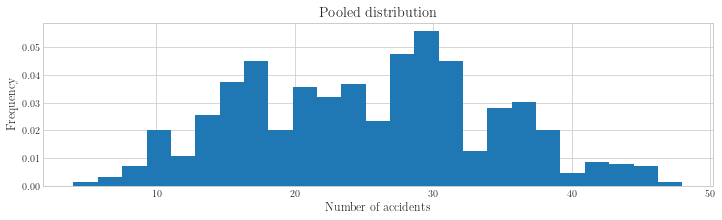

In [20]:
x = counts2010
y = counts2013
pool = np.concatenate([x,y])
np.random.shuffle(pool)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(pool, 
         bins = 25, 
         density = True)
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.title("Pooled distribution")

Text(0.5, 0, 'Difference in the mean')

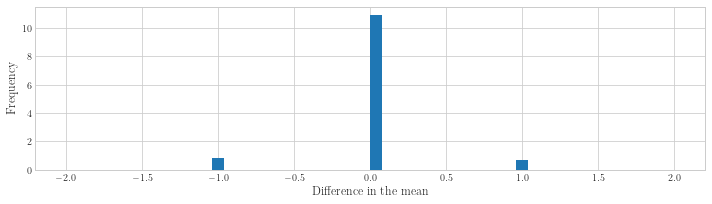

In [21]:
N = 10000 # number of samples
diff = np.arange(N)
for i in np.arange(N):
    p1 = [random.choice(pool) for _ in np.arange(n)]
    p2 = [random.choice(pool) for _ in np.arange(n)]
    diff[i] = (np.mean(p1)-np.mean(p2))

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plt.hist(diff, bins = 50, density = True)
plt.ylabel('Frequency')
plt.xlabel('Difference in the mean')

In [22]:
# counting how many differences are larger than the observed one
diff2 = np.array(diff)
w1 = np.where(diff2 > p)[0]      
len(w1)

13

If there are $k$ sample pairs where the difference in mean is as big as or bigger than 0.05, the p-value is approximately $k/N$. In or case:

In [23]:
print('p-value (Simulation)=', len(w1)/float(N), '(', len(w1)/float(N)*100 ,'%)', 'Difference =', p)
if len(w1)/float(N)<0.05:
    print('The effect is likely')
else:
    print('The effect is not likely')

p-value (Simulation)= 0.0013 ( 0.13 %) Difference = 1.0986301369863014
The effect is likely


We have defined the effect as a difference in mean as
big or bigger than the observed difference, taking into account the sign. A test like this is called *one-sided*.

If the relevant question is whether accident rates are different, then it
makes sense to test the absolute difference in means. This kind of test is called *two-sided*
because it  counts both sides of the distribution of differences.